Preprocessing for both SegPc 21 and DSB 2018 datasets

In [4]:
#get the train.zip for either of the datasets
import zipfile

# Specify the path of the zip file
zip_path = '/content/drive/MyDrive/train.zip'

# Specify the path where you want to extract the contents of the zip file
extracted_path = '/content/pytorch-nested-unet/inputs/data-science-bowl-2018/'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents of zip file in current directory
    zip_ref.extractall(extracted_path)

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [8]:
import os
import shutil

# Set the paths for the original images and masks directories
original_images_dir = '/content/pytorch-nested-unet/inputs/data-science-bowl-2018/train/x'
original_masks_dir = '/content/pytorch-nested-unet/inputs/data-science-bowl-2018/train/y'

# Create a new directory to store the images and masks
new_dir = '/content/new_dir'
if not os.path.exists(new_dir):
    os.mkdir(new_dir)

# Get a list of all the image files in the original images directory
image_files = [f for f in os.listdir(original_images_dir) if os.path.isfile(os.path.join(original_images_dir, f))]

# Loop through each image file and create a new directory with the same name as the image file
for image_file in image_files:
    image_name = os.path.splitext(image_file)[0] # Get the image name without the extension
    new_image_dir = os.path.join(new_dir, image_name)
    os.mkdir(new_image_dir)

    # Create subdirectories for the image and mask
    image_subdir = os.path.join(new_image_dir, 'images')
    os.mkdir(image_subdir)
    mask_subdir = os.path.join(new_image_dir, 'masks')
    os.mkdir(mask_subdir)

    # Copy the original image to the images subdirectory
    shutil.copy2(os.path.join(original_images_dir, image_file), os.path.join(image_subdir, image_file))

    # Find the mask files that correspond to the current image file
    mask_name = image_name + '_'
    mask_files = [f for f in os.listdir(original_masks_dir) if f.startswith(mask_name)]

    # Loop through each mask file and copy it to the masks subdirectory
    for mask_file in mask_files:
        shutil.copy2(os.path.join(original_masks_dir, mask_file), os.path.join(mask_subdir, mask_file))


In [34]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm


def prepro():
    img_size = 96
    num_folders = 20  # Change this to limit the number of folders processed

    paths = glob('/content/new_dir/*') # Limit the number of folders to process

    os.makedirs('inputs/dsb2018_%d/images' % img_size, exist_ok=True)
    os.makedirs('inputs/dsb2018_%d/masks/0' % img_size, exist_ok=True)
    os.makedirs('inputs/dsb2018_%d/masks/1' % img_size, exist_ok=True)

    for i in tqdm(range(len(paths))):
        path = paths[i]
        img = cv2.imread(os.path.join(path, 'images',
                         os.path.basename(path) + '.bmp'))
        img_height, img_width, _ = img.shape
        mask1 = np.zeros((img_height, img_width), dtype=np.uint8)
        mask2 = np.zeros((img_height, img_width), dtype=np.uint8)
        for mask_path in glob(os.path.join(path, 'masks', '*')):
            try:
                mask_ = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask_.shape[:2] != (img_height, img_width):
                    raise ValueError("Mask size does not match image size")
                if np.any(mask_ == 20):
                    mask1[mask_ == 20] = 255
                if np.any(mask_ == 40):
                    mask2[mask_ == 40] = 255
            except ValueError as e:
                print("Error processing sample: ", mask_path)
                print("Error message: ", e)
                continue
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))
        if img.shape[2] == 4:
            img = img[..., :3]
        img = cv2.resize(img, (img_size, img_size))
        mask1 = cv2.resize(mask1, (img_size, img_size))
        mask2 = cv2.resize(mask2, (img_size, img_size))
        cv2.imwrite(os.path.join('inputs/dsb2018_%d/images' % img_size,
                    os.path.basename(path) + '.png'), img)
        cv2.imwrite(os.path.join('inputs/dsb2018_%d/masks/0' % img_size,
                    os.path.basename(path) + '.png'), mask1)
        cv2.imwrite(os.path.join('inputs/dsb2018_%d/masks/1' % img_size,
                    os.path.basename(path) + '.png'), mask2)

In [ ]:
prepro()

Script for converting masks to json


In [36]:
!git clone https://github.com/brunobelloni/binary-to-coco-json-converter.git
%cd /content/pytorch-nested-unet/binary-to-coco-json-converter
!pip install -r requirements.txt


Cloning into 'binary-to-coco-json-converter'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 147 (delta 38), reused 145 (delta 36), pack-reused 0
Receiving objects: 100% (147/147), 5.60 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/pytorch-nested-unet/binary-to-coco-json-converter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-p

Created 206 annotations for images in folder: /content/pytorch-nested-unet/inputs/dsb2018_96/masks/


In [ ]:
!python main.py #change the label name as per your need in main.py

Unet++:

In [ ]:
!git clone https://github.com/4uiiurz1/pytorch-nested-unet.git
%cd /content/pytorch-nested-unet
!pip install -r requirements.txt
!python train.py --dataset dsb2018_96 --arch NestedUNet --num_classes 2 --epochs 50 --deep_supervision "True"

In [ ]:
!python train.py --dataset dsb2018_96 --arch NestedUNet --loss LovaszHingeLoss --epochs 200

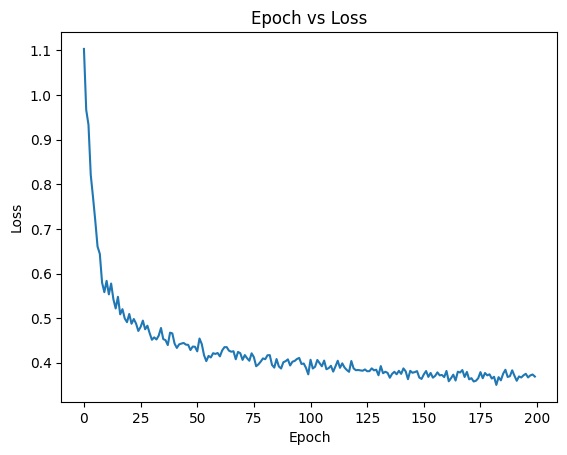

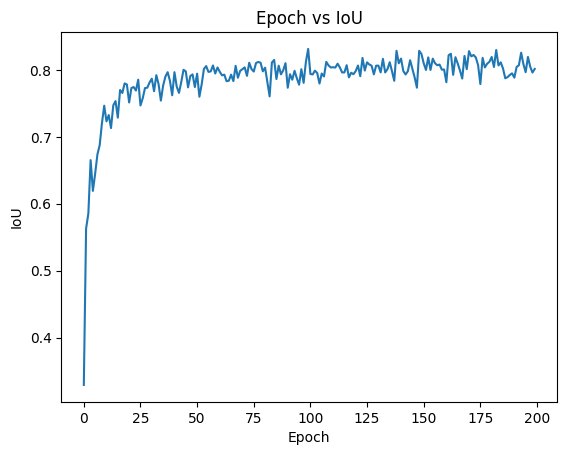

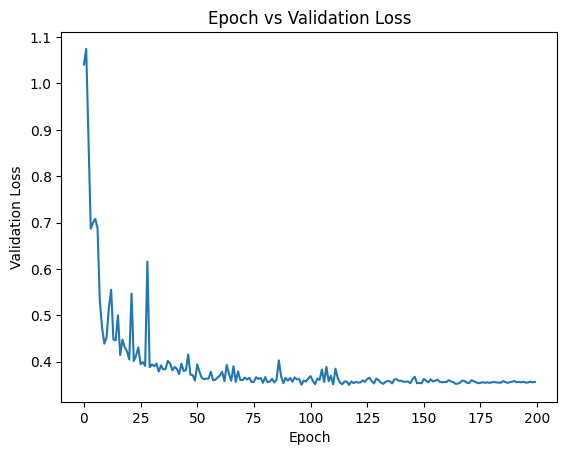

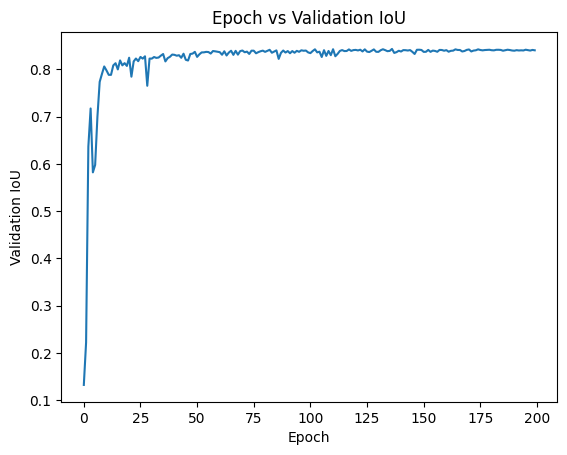

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log data from the csv file
log_file = '/content/pytorch-nested-unet/models/dsb2018_96_NestedUNet_woDS/log.csv'
log_data = pd.read_csv(log_file)

# Plot epoch vs loss
plt.plot(log_data['epoch'], log_data['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.show()

# Plot epoch vs IoU
plt.plot(log_data['epoch'], log_data['iou'])
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Epoch vs IoU')
plt.show()

# Plot epoch vs validation loss
plt.plot(log_data['epoch'], log_data['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Epoch vs Validation Loss')
plt.show()

# Plot epoch vs validation IoU
plt.plot(log_data['epoch'], log_data['val_iou'])
plt.xlabel('Epoch')
plt.ylabel('Validation IoU')
plt.title('Epoch vs Validation IoU')
plt.show()

# detectron2

In [37]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-9yv6e70m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-9yv6e70m
  Resolved https://github.com/facebookresearch/fvcore.git to commit fcc14bb0016408ddd818ddb0998f3df0e4e1381c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65380 sha256=be5de801aae2de5890ddff1b0cd5a3202e63a2add69e8fab0314d95ae163948d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3ro2gpe/wheels/8f/cb/6a/3b7ac0e01781855ca3d1417ebf9e15e20d5b7fe37ab063aa50
  Created wheel for iopath: filename=

'2.0.1+cu118'

In [7]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15119, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 15119 (delta 71), reused 100 (delta 52), pack-reused 14979
Receiving objects: 100% (15119/15119), 6.17 MiB | 20.20 MiB/s, done.
Resolving deltas: 100% (10940/10940), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2


In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fruits_nuts", {}, "/content/pytorch-nested-unet/binary-to-coco-json-converter/output/test.json", "/content/pytorch-nested-unet/inputs/dsb2018_96/images")

In [3]:
fruits_nuts_metadata = MetadataCatalog.get("fruits_nuts")
dataset_dicts = DatasetCatalog.get("fruits_nuts")

[06/19 11:59:08 d2.data.datasets.coco]: Loaded 20 images in COCO format from /content/pytorch-nested-unet/binary-to-coco-json-converter/output/test.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



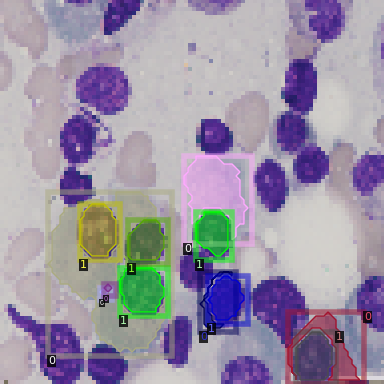

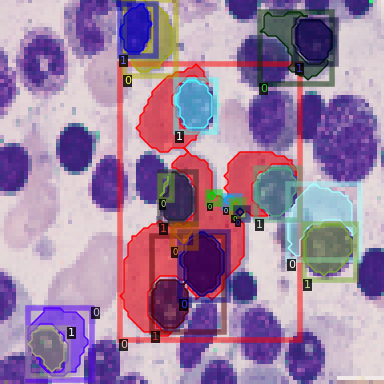

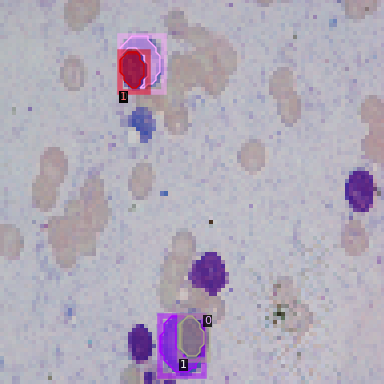

In [8]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=4)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruits_nuts",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/19 12:05:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 231MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/19 12:05:52 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/19 12:06:03 d2.utils.events]:  eta: 0:01:36  iter: 19  total_loss: 2.588  loss_cls: 0.8127  loss_box_reg: 0.7794  loss_mask: 0.6637  loss_rpn_cls: 0.2174  loss_rpn_loc: 0.07749    time: 0.3398  last_time: 0.3862  data_time: 0.0199  last_data_time: 0.0207   lr: 0.0012854  max_mem: 1767M
[06/19 12:06:17 d2.utils.events]:  eta: 0:01:28  iter: 39  total_loss: 1.842  loss_cls: 0.5089  loss_box_reg: 0.6648  loss_mask: 0.4576  loss_rpn_cls: 0.1019  loss_rpn_loc: 0.06029    time: 0.3366  last_time: 0.3197  data_time: 0.0069  last_data_time: 0.0052   lr: 0.0026174  max_mem: 1769M
[06/19 12:06:24 d2.utils.events]:  eta: 0:01:22  iter: 59  total_loss: 1.555  loss_cls: 0.4646  loss_box_reg: 0.5231  loss_mask: 0.3448  loss_rpn_cls: 0.07498  loss_rpn_loc: 0.0656    time: 0.3363  last_time: 0.3079  data_time: 0.0108  last_data_time: 0.0056   lr: 0.0039494  max_mem: 1769M
[06/19 12:06:30 d2.utils.events]:  eta: 0:01:12  iter: 79  total_loss: 1.248  loss_cls: 0.3967  loss_box_reg: 0.4463  loss_mask

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruits_nuts", )
predictor = DefaultPredictor(cfg)

[06/19 12:09:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

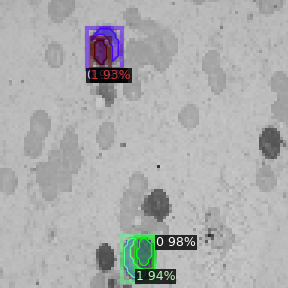

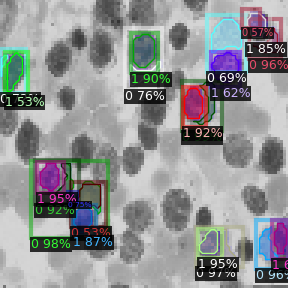

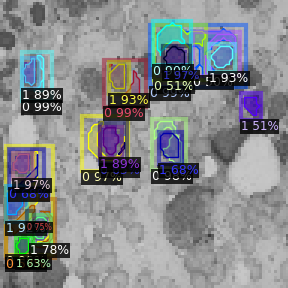

In [11]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata,
                   scale=3,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## Benchmark inference speed

In [12]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.10,fps:10.18
